In [1]:
import wfdb
import numpy as np
import os

import scipy.io
import tensorflow as tf
from tensorflow import  keras
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler,StandardScaler,scale
from skimage.measure import block_reduce
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,LSTM, MaxPooling1D, Dense, Flatten, Dropout, GlobalMaxPooling1D,BatchNormalization
from keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def function(muscle,disease, label_map):
    k=0
    for i in range (len(label_map)):
        if muscle in label_map[i]:
            if disease in label_map[i]:
                k=k+1
    return k

In [3]:
def scale_data_standard(X_train,X_test):
    #divide by variance and subtract mean for data 
    scaler = StandardScaler()
    data = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train ,X_test

In [4]:
def gen_tensors_list(data,dim):
    dataset  = list()
    for i in range (len(data)):
        arg = tf.convert_to_tensor(data[i], dtype=tf.float32)
        arg = tf.reshape(arg,dim)
        dataset.append(arg)

    return dataset

In [5]:
def windowing_fun(data,window_size=23437,overlap=14062):
    windowed_data = [data[j][i : i + window_size] for j in range(0,len(data)) for i in range(0, len(data[j]), window_size-overlap)]
    final_data = [windowed_data[i] for i in range(len(windowed_data)) if len(windowed_data[i]) == window_size ]
    return final_data

In [6]:
def remove_nan_rows(arr,Y):
    # Find the rows with NaN values
    nan_rows = np.isnan(arr).any(axis=1)

    # Convert the boolean array to integer indices
    index_to_remove = np.where(nan_rows)[0]

    # Remove the rows with NaN values
    arr = np.delete(arr, index_to_remove, axis=0)
    Y = np.delete(Y, index_to_remove, axis=0)

    return arr,Y

In [7]:
def noise_for_samples(data, Y):
    data = np.array(data)
    noise = np.random.normal(0, 1, size=data.shape)
    noisy_data = np.add(data, noise)
    data = np.concatenate((data, noisy_data))
    Y = np.concatenate((Y, Y))
    return noisy_data 

In [8]:
def preprocessing(X,Y):
    
    X = windowing_fun(X, 23437)
   
    X,Y = remove_nan_rows(X,Y)
    
    tensors_list = gen_tensors_list(X,(23437,1))
    
    return tensors_list,Y

In [9]:
def outputs(Y, X):
    
    last_index_normal = len(Y) - 1 - Y[::-1].index(1)
    last_index_myopathie = len(Y) - 1 - Y[::-1].index(0)
    
    windowed_normal = len(windowing_fun(X[:last_index_normal+1],23437))
    windowed_myopathie = len(windowing_fun(X[last_index_normal+1:],23437))
    
    return windowed_normal, windowed_myopathie


In [10]:
def last_index (Y):
    last_index_normal = len(Y) - 1 - Y[::-1].index(1)
    last_index_myopathie = len(Y) - 1 - Y[::-1].index(0)
    return last_index_normal, last_index_myopathie

In [11]:
def generate_dataframe(data,files):
    df = pd.DataFrame([], columns=['type_signal',"num_personne","muscle","num_enregistrement","signal"])
    windowed_data = [{"signal": data[j],"type_signal":files[j][5],"num_personne": files[j][6:8],"muscle": files[j][8:10],"num_enregistrement":files[j][10:12] } for j in range(0,len(data))]
    final_data = [windowed_data[i] for i in range(len(windowed_data))]
    df =df.append(final_data, ignore_index=True)
    #df =pd.concat([df, final_data])
    #df = pd.concat([df, pd.DataFrame.from_records(final_data)], ignore_index=True)
    return df

In [12]:
def NaN_values(signal_data_array):
    # Check if there are any NaN values in the data
    nan_indices = np.argwhere(np.isnan(signal_data_array))

    # Check if there are any empty values in the data
    empty_indices = np.argwhere(np.array([len(x) == 0 for x in signal_data_array]))
    np.set_printoptions(threshold=np.inf)

     #Print the indices of any NaN or empty values
    if len(nan_indices) > 0:
        print("Found NaN values ")
    else:
        print("none")
    if len(empty_indices) > 0:
        print("Found empty values")
    else:
        print("none")
    nan_indices.shape

In [13]:
import os
import wfdb
import numpy as np

database_dir = '/kaggle/input/emglab'

hea_files = [f for f in os.listdir(database_dir)]

# Initialize empty arrays to store the signal data and record names
signal_data_list = []
record_name_list = []
# Loop over each .hea file and read its signal data
for file in hea_files:
    if file.endswith(".hea"):
        record_name = os.path.splitext(file)[0] # Get the record name from the file name
        if ((record_name[5] == 'M') or (record_name[5] == 'C')): # Add the condition to check for the sixth character of the record name to be 'M' or 'C'
            record_path = os.path.join(database_dir, record_name) # Get the full path to the record
            record = wfdb.rdrecord(record_path) # Read the record
            signal_data = np.array(record.p_signal) # Get the signal data as a numpy array
            signal_data_list.append(signal_data) # Append the signal data to the list
            record_name_list.append(record_name) # Append the record name to the list

# Convert the list of signal data arrays to a 3D numpy array
signal_data_array = np.stack(signal_data_list)

print(record_name_list)


['N2001C03BB51', 'N2001C07BB51', 'N2001M02BB51', 'N2001C06BB65', 'N2001C07BB63', 'N2001C07BB76', 'N2001C09BB51', 'N2001C01BB61', 'N2001M03BB03', 'N2001M05BB60', 'N2001M07BB20', 'N2001M02BB61', 'N2001C06BB51', 'N2001M03BB10', 'N2001C03BB80', 'N2001C04BB73', 'N2001C09BB67', 'N2001C06BB57', 'N2001C04BB66', 'N2001M03BB08', 'N2001M07BB10', 'N2001M02BB06', 'N2001C06BB61', 'N2001C03BB64', 'N2001M03BB04', 'N2001C07BB57', 'N2001C09BB59', 'N2001C04BB52', 'N2001C02BB76', 'N2001C06BB73', 'N2001C01BB74', 'N2001M02BB59', 'N2001C04BB63', 'N2001C09BB57', 'N2001C02BB70', 'N2001C05BB54', 'N2001M04BB52', 'N2001C02BB65', 'N2001C06BB77', 'N2001C07BB66', 'N2001C01BB68', 'N2001C08BB60', 'N2001C07BB59', 'N2001M04BB54', 'N2001C08BB80', 'N2001C01BB59', 'N2001C09BB78', 'N2001C04BB64', 'N2001C03BB72', 'N2001M07BB15', 'N2001C04BB56', 'N2001M06BB08', 'N2001M05BB63', 'N2001C01BB72', 'N2001C02BB59', 'N2001M05BB59', 'N2001C04BB51', 'N2001M06BB15', 'N2001C04BB68', 'N2001M06BB12', 'N2001M07BB16', 'N2001C05BB61', 'N2001C

In [14]:
f=function('BB','N2001M' , record_name_list)
print('number of signals taken from patients with myopathy from the biceps brachii muscle ',f)

f=function('BB','N2001C' , record_name_list)
print('number of signals taken from normal people from the biceps brachii muscle ',f)

number of signals taken from patients with myopathy from the biceps brachii muscle  107
number of signals taken from normal people from the biceps brachii muscle  270


In [15]:
signal_data_array.shape

(377, 262124, 1)

In [16]:
# Combine the labels and signals arrays into a list of tuples
data = list(zip(record_name_list, signal_data_array))

# Sort the list of tuples by the first element (the labels)
sorted_data = sorted(data, key=lambda x: x[0])

# Extract the sorted signals into a new array
signal_data_array = [x[1] for x in sorted_data]

record_name_list = [x[0] for x in sorted_data]

In [17]:
print(np.shape(signal_data_array))
print(np.shape(record_name_list))

(377, 262124, 1)
(377,)


In [18]:
signal_data_array = np.delete(signal_data_array,np.s_[:70], axis=0)
record_name_list = np.delete(record_name_list,np.s_[:70], axis=0)

In [19]:
f=function('BB','N2001M' , record_name_list)
print('number of signals taken from patients with myopathy from the biceps brachii muscle ',f)

f=function('BB','N2001C' , record_name_list)
print('number of signals taken from normal people from the biceps brachii muscle ',f)

number of signals taken from patients with myopathy from the biceps brachii muscle  107
number of signals taken from normal people from the biceps brachii muscle  200


In [20]:
#check if there are NaN values
NaN_values(signal_data_array)

Found NaN values 
none


In [21]:
df = generate_dataframe(signal_data_array,record_name_list)

/tmp/ipykernel_31/879706199.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df =df.append(final_data, ignore_index=True)


In [22]:
df

,type_signal,num_personne,muscle,num_enregistrement,signal
0,C,03,BB,61,"[[1.8310826276035708], [0.6103608758678569], [..."
1,C,03,BB,62,"[[-7.9346913862821395], [-10.147249561303122],..."
2,C,03,BB,63,"[[-39.82604715037766], [-43.41191729610132], [..."
3,C,03,BB,64,"[[-51.27031357289998], [-26.932173647669185], ..."
4,C,03,BB,65,"[[95.21629663538567], [94.6822308690013], [93...."
...,...,...,...,...,...
302,M,07,BB,18,"[[1.9073777370870528], [2.059967956054017], [3..."
303,M,07,BB,19,"[[-8.010986495765621], [-4.425116350041963], [..."
304,M,07,BB,20,"[[13.885709925993744], [10.986495765621424], [..."
305,M,07,BB,21,"[[7.324330510414283], [7.782101167315176], [8...."


In [23]:
def f(row):
    return {"C":1,"M":0}[row["type_signal"]]

df["num_class"] =df.apply(f, axis=1) 

In [24]:
df

,type_signal,num_personne,muscle,num_enregistrement,signal,num_class
0,C,03,BB,61,"[[1.8310826276035708], [0.6103608758678569], [...",1
1,C,03,BB,62,"[[-7.9346913862821395], [-10.147249561303122],...",1
2,C,03,BB,63,"[[-39.82604715037766], [-43.41191729610132], [...",1
3,C,03,BB,64,"[[-51.27031357289998], [-26.932173647669185], ...",1
4,C,03,BB,65,"[[95.21629663538567], [94.6822308690013], [93....",1
...,...,...,...,...,...,...
302,M,07,BB,18,"[[1.9073777370870528], [2.059967956054017], [3...",0
303,M,07,BB,19,"[[-8.010986495765621], [-4.425116350041963], [...",0
304,M,07,BB,20,"[[13.885709925993744], [10.986495765621424], [...",0
305,M,07,BB,21,"[[7.324330510414283], [7.782101167315176], [8....",0


In [25]:
del signal_data_array,record_name_list

In [26]:
X = df['signal'].tolist()
Y = df['num_class'].tolist()
print(Y)
print(np.asarray(Y).shape)
print(np.asarray(X).shape)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(307,)
(307, 262124, 1)


In [27]:
last_index_normal, last_index_myopathie = last_index (Y)
last_index_normal, last_index_myopathie

(199, 306)

In [28]:
del df

In [29]:
windowed_normal,windowed_myopathie = outputs(Y, X)

In [30]:
Y = [1]*(windowed_normal) + [0]*(windowed_myopathie)
print(np.asarray(Y).shape)

(7982,)


In [31]:
print(np.asarray(X).shape)

(307, 262124, 1)


In [32]:
X = windowing_fun(X, 23437)

print(np.shape(X))
print(np.shape(Y))

(7982, 23437, 1)
(7982,)


In [33]:
X,Y = remove_nan_rows(X,Y)

print(np.shape(X))
print(np.shape(Y))

(7970, 23437, 1)
(7970,)


In [34]:
X = gen_tensors_list(X,(23437,1))

In [ ]:
#Split the data into training, validation, and testing sets
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25,random_state=20)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)
#random_state Controls the shuffling applied to the data before applying the split.
print(np.shape(X_test))
print(np.shape(X_train))
print(" ")
print(np.shape(Y_test))
print(np.shape(Y_train))


In [ ]:
print(np.shape(X))
print(np.shape(Y))

In [ ]:
from keras.regularizers import l2
model = Sequential([
    
    #Conv1D(#of filters, filters size, activation function)
    #in keras for the first layer we always need to mention the input shape
    Conv1D(32,  kernel_size=13, padding='valid', dilation_rate=1,activation = 'relu', input_shape = (23437,1),kernel_initializer='he_normal'), 
    
    BatchNormalization(),
    Dropout(0.2),
    #LAYER2
    Conv1D(64, kernel_size=11, padding='valid' , dilation_rate=2, activation = 'relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001)),
    
    BatchNormalization(),
 
    Dropout(0.3),
    #LAYER3
    Conv1D(128, kernel_size=9, padding='valid', dilation_rate=3, activation = 'relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001)),
    
    BatchNormalization(),
    
    Dropout(0.4),
    
    Conv1D(256, kernel_size=7, padding='valid', dilation_rate=4, activation = 'relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.01)),
    
    BatchNormalization(),
    
    #GlobalMaxPooling1D layer
    GlobalMaxPooling1D(data_format = 'channels_last'),
    
   # Flatten(),
    
    #FC Layers:
    
    #LAYER4
    #Dense : fully connected  Dense(#neurons, activation function )
    
    Dense(128, activation = 'relu'),
    
    BatchNormalization(),
    
    Dropout(0.3),
    
    #LAYER5
    Dense(1, activation = 'sigmoid')
    
    
])

model.summary()


In [38]:
# Set the initial learning rate
lr = 1e-3
opt = Adam(learning_rate=lr, beta_1=0.9,beta_2=0.999, amsgrad= False, epsilon=None)


# Create the ReduceLROnPlateau callback to decrease the learning rate by a factor of 10
# when the validation loss doesn't improve for 5 consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-10)

# Create the EarlyStopping callback to stop training if the validation loss doesn't improve
# for 20 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=25, verbose=1)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model with early stopping
history = model.fit(
    
    x = np.asarray(X_train),
    y = np.asarray(Y_train),
    validation_split = 0.2,
    #validation_data = (np.asarray(X_val), np.asarray(Y_val)),
    shuffle=True,
    epochs=100,
    batch_size=16,
    callbacks=[reduce_lr, early_stop]

)

299/299 [==============================] - 129s 395ms/step - loss: 3.4419 - accuracy: 0.7484 - val_loss: 1.8283 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 2/100
299/299 [==============================] - 121s 403ms/step - loss: 1.2704 - accuracy: 0.8293 - val_loss: 1.3985 - val_accuracy: 0.6012 - lr: 0.0010
Epoch 3/100
299/299 [==============================] - 121s 404ms/step - loss: 0.8104 - accuracy: 0.8490 - val_loss: 0.7572 - val_accuracy: 0.8746 - lr: 0.0010
Epoch 4/100
299/299 [==============================] - 121s 404ms/step - loss: 0.7096 - accuracy: 0.8653 - val_loss: 0.7071 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 5/100
299/299 [==============================] - 118s 393ms/step - loss: 0.6551 - accuracy: 0.8979 - val_loss: 0.6599 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 6/100
299/299 [==============================] - 118s 393ms/step - loss: 0.6394 - accuracy: 0.9159 - val_loss: 0.9092 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 7/100
299/299 [==============================]

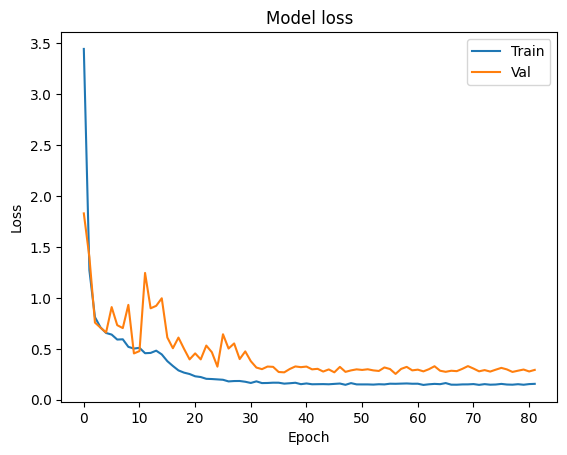

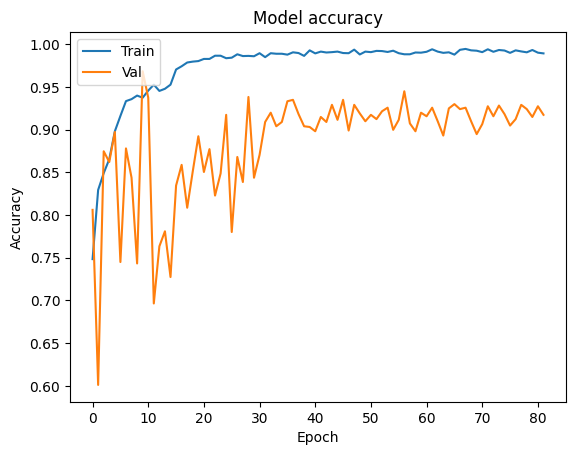

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [39]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
print(history.history.keys())


In [40]:
score = model.evaluate(np.asarray(X_test),np.asarray (Y_test) ) 

63/63 [==============================] - 13s 183ms/step - loss: 0.2860 - accuracy: 0.9247


In [41]:
#model.save("subject-independent-als-normal.h5")

In [42]:
y_pred = model.predict(np.asarray(X_test))

63/63 [==============================] - 11s 176ms/step


In [43]:
y_predicted_labels = [{0:"Myopathie",1:"Normal"}[i] for i in np.argmax(y_pred,axis=1)]

In [44]:
y_true_labels = [{0:"Myopathie",1:"Normal"}[i] for i in Y_test]

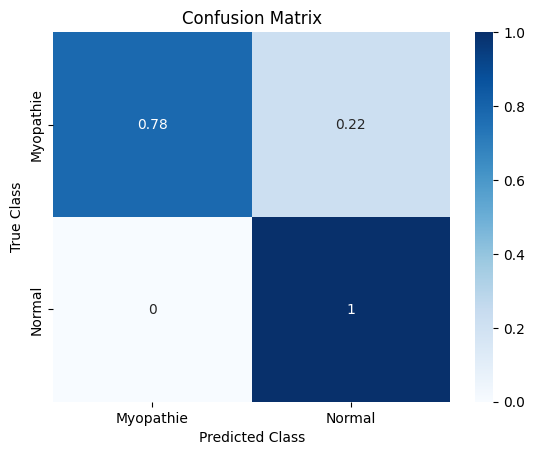

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = y_pred >= 0.5
# Generate confusion matrix
con_mat = confusion_matrix(Y_test,y_pred)

# Normalize confusion matrix
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

# Create DataFrame from normalized confusion matrix
con_mat_df = pd.DataFrame(con_mat_norm,
                           index=['Myopathie', 'Normal'],
                           columns=['Myopathie', 'Normal'])

# Create heatmap from DataFrame
sns.heatmap(con_mat_df, annot=True, cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

# Show plot
plt.show()


In [46]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88       679
           1       0.90      1.00      0.95      1314

    accuracy                           0.92      1993
   macro avg       0.95      0.89      0.91      1993
weighted avg       0.93      0.92      0.92      1993

